In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

** Feature Engineering - Sunlight/Energy received by a 30 by 30 patch **  
The idea behind this feature is that different trees respond differently to amount of sunlight/energy.  
The dataset provides values of Hillshade for every patch at 9 am, 12 noon and 3 pm. Hillshade is a measure of sunlight incident upon a patch. It has values between 0 and 255 where 0 represents absence of sunlight. Hillshade takes into account Sun's elevation, latitude, slope and aspect of the patch.      
This engineered feature indicates the relative amount of sunlight/energy a patch receives. The assumption is that amount of sunlight is more directly correlated to Cover_Type than individual measures of Hillshade and hence is a better predictor. The amount of sunlight is calculated as Area under the curve of the below figure.  
This figure below is a simplification of the curve because the $f(time)=Hillshade$ is not a linear function. But despite the simplification we get an increase in accuracy.  
To cacluate the area, we measured time in seconds.  
After calculating energy, dropping the original hilshade features increased the accuracy

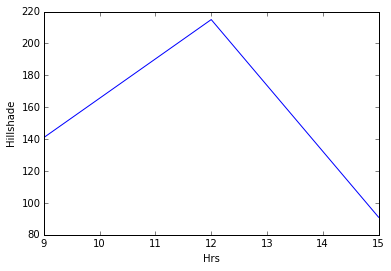

In [11]:
plt.figure() 

hillshade = [141, 215, 91]        # Hillshade values at 9 am, 12 noon and 3 pm
time = [9, 12, 15]                # Time at 9 am, 12 noon and 3 pm
plt.subplot(1, 1, 1)
plt.plot([9, 12, 15], [141, 215, 91])
x_l = plt.xlabel('Hrs')
y_l = plt.ylabel('Hillshade')

In [ ]:
data['Energy'] = ((data['Hillshade_9am']+data['Hillshade_Noon'])/2)*10800 + ((data['Hillshade_Noon']+data['Hillshade_3pm'])/2)*10800
data.drop('Hillshade_9am', axis=1, inplace=True)
data.drop('Hillshade_Noon', axis=1, inplace=True)
data.drop('Hillshade_3pm', axis=1, inplace=True)

** Feature Engineering - Is patch closer to Roadway and Firepoint than water **  
The idea behind these features is that hydrology affect on trees wil be impacted if human effects (Roadways) and natural hazards (fires) are nearby.   
These features indicate if roadways and fire points are closer to a patch than hydrology.  
These features have improved accuracy

In [ ]:
data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])

** Feature Engineering - Creating features of differentiate Cover_Types 1 and 2 **  
The test data is unusual because it is heavily skewed towards Cover_Types 1 and 2. Additionally, train data shows that these two cover types are very similar.  
** Nate's bivariate distribution contour plot will demonstrate this point **  
To induce variation in the data we have added two extra features by multiplying features together. Multiplication will amplify the variation.  
These features have increased the accuracy

In [ ]:
data['ShdHvdH'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
data['hdFPhdR'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 

** All feature engineering wrapped in a function **

In [ ]:
#Azimuth Adjustment
def adjust(x): 
    if x+180>360: 
        return x-180 
    else: 
        return x+180 

def feature_engineering(data_to_tranform):
    data = data_to_tranform.copy()
    #Feature Engineering
    data['Aspect2'] = data.Aspect.map(adjust) 
    data['Energy'] = ((data['Hillshade_9am']+data['Hillshade_Noon'])/2)*10800 + ((data['Hillshade_Noon']+data['Hillshade_3pm'])/2)*10800
    data.drop('Hillshade_9am', axis=1, inplace=True)
    data.drop('Hillshade_Noon', axis=1, inplace=True)
    data.drop('Hillshade_3pm', axis=1, inplace=True)
    data['Above_Sea_Level'] = data.Vertical_Distance_To_Hydrology < 0 
    data['Vertical_To_Water'] = data.Elevation-data.Vertical_Distance_To_Hydrology 
    data['Horizontal_To_Water'] = data.Elevation-data.Horizontal_Distance_To_Hydrology*0.2 
    data['Pythagorean_To_Water'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5 
    data['Water_And_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points'] 
    data['Water_Less_Fire'] = abs(data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']) 
    data['Water_And_Roadway'] = abs(data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']) 
    data['Water_Less_Roadway'] = abs(data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']) 
    data['Fire_And_Roadway'] = abs(data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']) 
    data['Fire_Less_Roadway'] = abs(data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']) 
    data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
    data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])
    # Feature Engineering - Many features multiplied together
    data['Extra_1'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
    #
    data['Extra_2'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 
    #
    return data


** Handling Cover_Types 1 and 2 separately - Implementation of Nate's idea **  
Here we are retraining the same classifier with the same set of engineered features but only on train data subset on Cover_Types 1 and 2. The idea is to use this classifier to predict Cover_Types only for those test data observations, which were predicted as Cover_Types 1 and 2 by the Global classifier.  
This did not improve the accuracy but we are mentioning this here because we think it is interesting.  
As the subset classifier is wrapped in a function below (subset_classifier()), so different types of classifiers can be plugged in and tested as well.

In [ ]:
# Processing Cover_Type 1 and 2 using a separate classifier trained only on Cover_type 1 and 2
# Then update global predictions with the subset predictions

# Reading data from filesystem
train_data = pd.read_csv(os.path.join('train.csv'), header=0)
test_data = pd.read_csv(os.path.join('test.csv'), header=0) 

# Subset of train_data for Cover_Types 1 and 2
cover_type_1 = train_data[train_data['Cover_Type']==1]
cover_type_2 = train_data[train_data['Cover_Type']==2] 
cover_type_1_and_2 = pd.concat([cover_type_1, cover_type_2], ignore_index=True)
train_labels_subset = cover_type_1_and_2['Cover_Type'].as_matrix() 
cover_type_1_and_2.drop(['Cover_Type', 'Id'], axis=1, inplace=True)

# Subset of test data
predicted_1 = np.where(predictions == 1)[0]                       # Index of predictions with Cover_Type==1 
predicted_2 = np.where(predictions == 2)[0]                       # Index of predictions with Cover_Type==2   
predicted_1_or_2 = np.hstack((predicted_1, predicted_2))
test_data_subset = test_data.ix[predicted_1_or_2]
test_data_subset.drop(['Id'], axis=1, inplace=True) 

# Applying feature engineering to train subset
train_tranformed_subset = feature_engineering(cover_type_1_and_2)
train_matrix_subset = train_tranformed_subset.as_matrix()

# Applying feature engineering to test subset
test_transformed = feature_engineering(test_data_subset)
test_X_subset = test_transformed.as_matrix() 

# Creating function to classify subset
def subset_classifier(train_data, train_labels, test_data):
    etc_subset = ExtraTreesClassifier(n_estimators = 600, max_features = 0.3)
    adbc_subset = AdaBoostClassifier(etc_subset, n_estimators = 600) 
    adbc_subset.fit(train_data, train_labels)
    predictions_subset = adbc_subset.predict(test_data).astype(int)
    return predictions_subset

predictions_subset = subset_classifier(train_matrix_subset, train_labels_subset, test_X_subset)

# Over writing global predictions with subset predictions
# Global predictions is in variable 'predictions'
for i, val in enumerate(predicted_1_or_2):
    predictions[val] = predictions_subset[i]